In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import pickle
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('datasets/features-label-bow.pkl')
df_copy = df.copy()

In [3]:
df_copy.shape[0]

43290

In [3]:
df_copy.head()

,CIK,file_id,year,roe,opinc,nopinc,token_count,roe_next_year,tone,bow_vector,bow_normalised
0,1750,3,2005,0.095362,0.131652,-0.015174,2120,0.127945,-0.000472,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1750,4,2006,0.127945,0.149182,-0.022282,3219,0.139220,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1750,7,2009,0.063607,0.105913,-0.030043,3364,0.088296,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1750,8,2010,0.088296,0.136418,-0.040048,3045,0.079613,-0.000328,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1750,9,2011,0.079613,0.138888,-0.026679,2503,0.061607,-0.000799,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Retrieve train and test file_ids

In [4]:
train_ids = pd.read_csv('train-test-ids/train-ids.csv')
test_ids = pd.read_csv('train-test-ids/test-ids.csv')

train_data = df_copy[df_copy['file_id'].isin(train_ids['file_id'].astype(str))]
test_data = df_copy[df_copy['file_id'].isin(test_ids['file_id'].astype(str))]

In [5]:
train_data.shape

(32113, 11)

In [6]:
test_data.shape

(11177, 11)

In [7]:
# define evaluation metrics
def get_test_mse(model, test_features, test_label):
    test_pred = model.predict(test_features)
    return mean_squared_error(test_label, test_pred)

def get_test_mae(model, test_features, test_label):
    test_pred = model.predict(test_features)
    return mean_absolute_error(test_label, test_pred)

# n: length of test data
# p: number of predictors
def get_test_adj_r2(model, test_features, test_label, n, p):
    test_pred = model.predict(test_features)
    r2 = r2_score(test_label, test_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

# Part 4: ROE + BoW

Model1.3 ROE_t, bow_vector_t -> ROE_t+1

In [8]:
# features concatenation
train_features_m1_3 = np.concatenate((np.array(train_data['bow_normalised'].tolist()), train_data['roe'].values.reshape(-1, 1)), axis=1)
train_label_m1_3 = train_data['roe_next_year'].values

test_features_m1_3 = np.concatenate((np.array(test_data['bow_normalised'].tolist()), test_data['roe'].values.reshape(-1, 1)), axis=1)
test_label_m1_3 = test_data['roe_next_year'].values

In [9]:
# normalisation
std_train = np.std(train_features_m1_3, axis=0)
std_test = np.std(test_features_m1_3, axis=0)

epsilon = 1e-8
std_train[std_train == 0] = epsilon
std_test[std_test == 0] = epsilon

train_features_m1_3_norm = (train_features_m1_3 - np.mean(train_features_m1_3, axis=0)) / std_train
test_features_m1_3_norm = (test_features_m1_3 - np.mean(test_features_m1_3, axis=0)) / std_test

Model1.3 Linear regression

In [54]:
model1_3_lr = LinearRegression()
model1_3_lr.fit(train_features_m1_3_norm, train_label_m1_3)

LinearRegression()

In [14]:
model1_3_lr_mse = get_test_mse(
    model1_3_lr,
    test_features_m1_3_norm,
    test_label_m1_3
)
model1_3_lr_mse

3.9767595014391683e+24

In [17]:
print('MAE: ', get_test_mae(
    model1_3_lr,
    test_features_m1_3_norm,
    test_label_m1_3
))

n = test_data.shape[0]
p = test_features_m1_3.shape[1]
print('Adjusted R^2: ', get_test_adj_r2(
    model1_3_lr,
    test_features_m1_3_norm,
    test_label_m1_3,
    n,
    p
))

MAE:  95317924400.73193
Adjusted R^2:  -8.059785430075617e+25


Model1.3 Ridge regression

In [80]:
model1_3_ridge = RidgeCV(alphas=[0.1, 1, 10, 100, 500, 1000])
model1_3_ridge.fit(train_features_m1_3_norm, train_label_m1_3)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


RidgeCV(alphas=[0.1, 1, 10, 100, 500, 1000], store_cv_values=True)

In [59]:
model1_3_ridge.alpha_

1000.0

In [60]:
model1_3_ridge_mse = get_test_mse(
    model1_3_ridge,
    test_features_m1_3_norm,
    test_label_m1_3
)
model1_3_ridge_mse

0.04182540941738744

In [ ]:
model1_3_ridge_mae = get_test_mae(
    model1_3_ridge,
    test_features_m1_3_norm,
    test_label_m1_3
)
model1_3_ridge_mae

In [ ]:
n = test_data.shape[0]
p = test_features_m1_3.shape[1]
model1_3_ridge_adj_r2 = get_test_adj_r2(
    model1_3_ridge,
    test_features_m1_3_norm,
    test_label_m1_3,
    n,
    p
)
model1_3_ridge_adj_r2

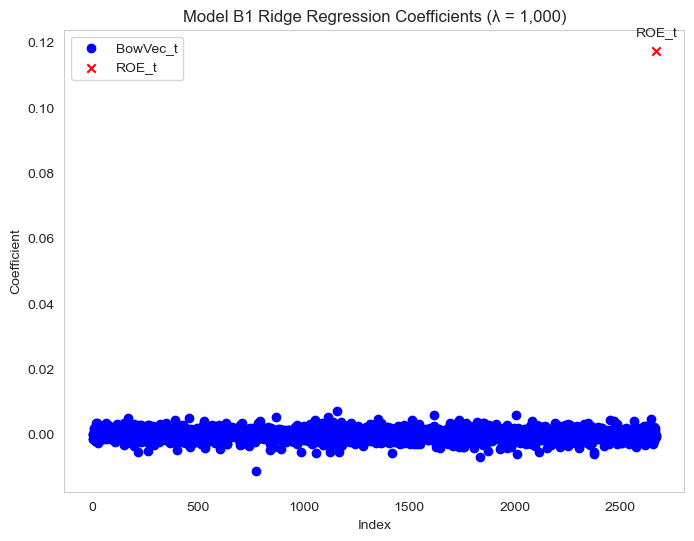

In [46]:
# Draw coefficients plot
model1_3_ridge_pkl = pickle.load(open('finalised-models/model1-3-ridge.pkl', 'rb'))
coefs = model1_3_ridge_pkl.coef_
coefs_bow = coefs[:-1]
coefs_roe = coefs[-1:]

plt.figure(figsize=(8, 6))
plt.scatter(range(len(coefs_bow)), coefs_bow, c='blue', label='BowVec_t', marker='o')
plt.scatter(range(len(coefs_bow), len(coefs_bow) + len(coefs_roe)), coefs_roe, c='red', label='ROE_t', marker='x')
plt.annotate('ROE_t', (2671, coefs_roe[0]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Index')
plt.ylabel('Coefficient')
plt.title('Model B1 Ridge Regression Coefficients (λ = 1,000)')
plt.legend()
plt.grid()
plt.show()

Model1.3 Decision tree

In [56]:
# with trial hyperparameters
model1_3_dt = DecisionTreeRegressor(max_depth=3)
model1_3_dt.fit(train_features_m1_3_norm, train_label_m1_3)

DecisionTreeRegressor(max_depth=3)

In [57]:
model1_3_dt_mse = get_test_mse(
    model1_3_dt,
    test_features_m1_3_norm,
    test_label_m1_3
)
model1_3_dt_mse

0.03968238492013644

In [58]:
dt_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [100, 200, 300, 500, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

model1_3_dt_tune = GridSearchCV(
    estimator=model1_3_dt,
    param_grid=dt_params,
    n_jobs=-1
)
model1_3_dt_tune.fit(train_features_m1_3_norm, train_label_m1_3)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/l

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [100, 200, 300, 500, 800],
                         'splitter': ['best', 'random']})

In [59]:
model1_3_dt_tune.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 300,
 'splitter': 'best'}

In [60]:
model1_3_dt_best = model1_3_dt_tune.best_estimator_
model1_3_dt_best_mse = get_test_mse(
    model1_3_dt_best,
    test_features_m1_3_norm,
    test_label_m1_3
)
model1_3_dt_best_mse

0.0387150911265441

In [61]:
model1_3_dt_best_mae = get_test_mae(
    model1_3_dt_best,
    test_features_m1_3_norm,
    test_label_m1_3
)
model1_3_dt_best_mae

0.12171548039590177

In [70]:
n = test_data.shape[0]
p = test_features_m1_3.shape[1]
model1_3_dt_best_adj_r2 = get_test_adj_r2(
    model1_3_dt_best,
    test_features_m1_3_norm,
    test_label_m1_3,
    n,
    p
)
model1_3_dt_best_adj_r2

0.21535278340858666

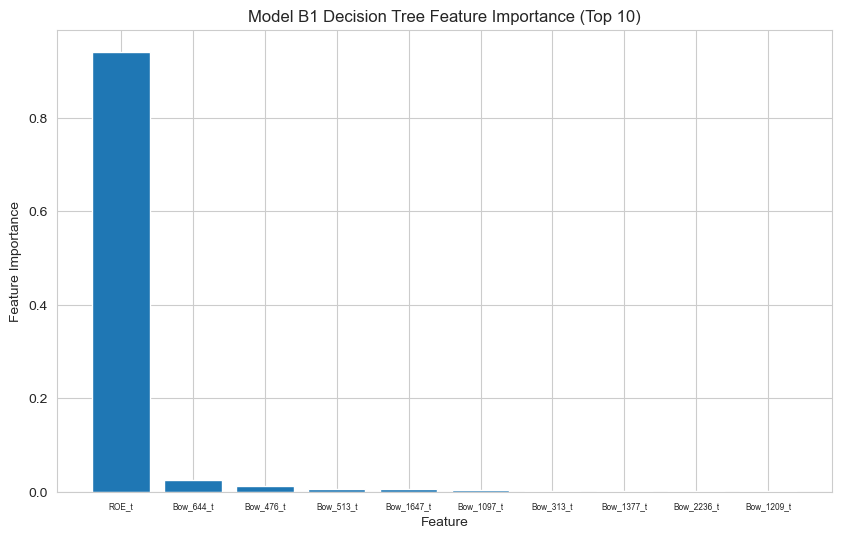

In [71]:
model1_3_dt_pkl = pickle.load(open('finalised-models/model1-3-dt.pkl', 'rb'))
feature_importances = model1_3_dt_pkl.feature_importances_
feature_names = [f"Bow_{i}_t" for i in range(1, 2671)] + ['ROE_t']

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(0, 10), sorted_feature_importances[:10])
plt.xticks(range(0, 10), sorted_feature_names[:10], fontsize=6)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Model B1 Decision Tree Feature Importance (Top 10)')
plt.show()

Model1.3 Gradient boosting

In [63]:
model1_3_gb = GradientBoostingRegressor()

In [64]:
model1_3_gb.fit(train_features_m1_3_norm, train_label_m1_3)

GradientBoostingRegressor()

In [65]:
model1_3_gb_mse = get_test_mse(
    model1_3_gb,
    test_features_m1_3_norm,
    test_label_m1_3
)
model1_3_gb_mse

0.03776593550842181

In [66]:
model1_3_gb_mae = get_test_mae(
    model1_3_gb,
    test_features_m1_3_norm,
    test_label_m1_3
)
model1_3_gb_mae

0.1196531790948841

In [71]:
n = test_data.shape[0]
p = test_features_m1_3.shape[1]
model1_3_gb_adj_r2 = get_test_adj_r2(
    model1_3_gb,
    test_features_m1_3_norm,
    test_label_m1_3,
    n,
    p
)
model1_3_gb_adj_r2

0.23458952784598086

In [88]:
gb_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 10, 50, 100, 200],
    'min_samples_split': [2, 10, 100, 200, 500, 1000],
    'min_samples_leaf': [1, 10, 100, 200, 500, 1000],
}

# use RandomizedSearchCV for computational limitation
model1_3_gb_tune = RandomizedSearchCV(
    estimator=model1_3_gb,
    param_distributions=gb_params,
    random_state=42,
    n_iter=100,
    n_jobs=-1
)
model1_3_gb_tune.fit(train_features_m1_3_norm, train_label_m1_3)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [3, 10, 50, 100, 200],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42)

In [89]:
model1_3_gb_tune.best_params_

{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 10}

In [90]:
model1_3_gb_best = model1_3_gb_tune.best_estimator_
model1_3_gb_best_mse = get_test_mse(
    model1_3_gb_best,
    test_features_m1_3_norm,
    test_label_m1_3
)
model1_3_gb_best_mse

0.03935585158591424

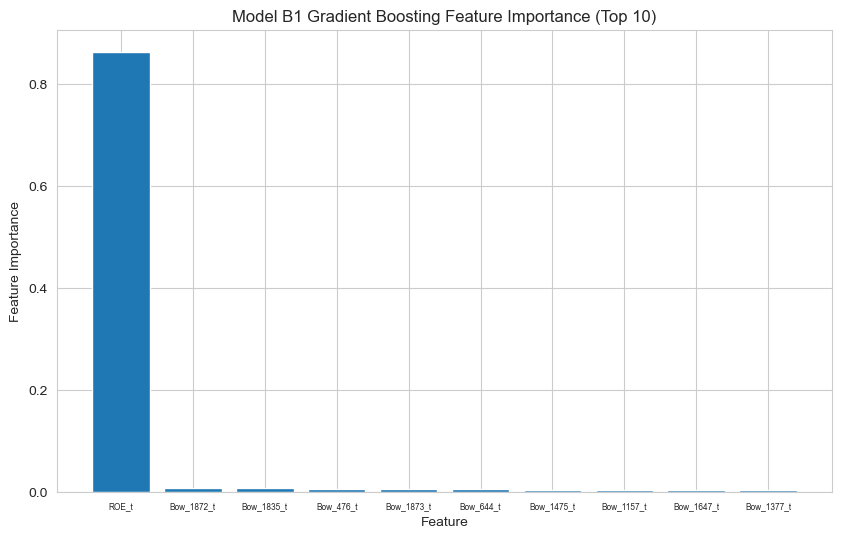

In [78]:
model1_3_gb_pkl = pickle.load(open('finalised-models/model1-3-gb.pkl', 'rb'))
feature_importances = model1_3_gb_pkl.feature_importances_
feature_names = [f"Bow_{i}_t" for i in range(1, 2671)] + ['ROE_t']

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(0, 10), sorted_feature_importances[:10])
plt.xticks(range(0, 10), sorted_feature_names[:10], fontsize=6)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Model B1 Gradient Boosting Feature Importance (Top 10)')
plt.show()

In [72]:
pickle.dump(model1_3_lr, open('finalised-models/model1-3-lr.pkl', 'wb'))
pickle.dump(model1_3_ridge, open('finalised-models/model1-3-ridge.pkl', 'wb'))
pickle.dump(model1_3_dt_best, open('finalised-models/model1-3-dt.pkl', 'wb'))
pickle.dump(model1_3_gb, open('finalised-models/model1-3-gb.pkl', 'wb'))

# OPINC + NOPINC + BoW

Model2.3 OPINC_t, NOPINC_t, bow_vector_t -> ROE_t+1

In [18]:
# features concatenation
train_features_m2_3 = np.concatenate((np.array(train_data['bow_normalised'].tolist()), train_data['opinc'].values.reshape(-1, 1), train_data['nopinc'].values.reshape(-1, 1)), axis=1)
train_label_m2_3 = train_data['roe_next_year'].values

test_features_m2_3 = np.concatenate((np.array(test_data['bow_normalised'].tolist()), test_data['opinc'].values.reshape(-1, 1), test_data['nopinc'].values.reshape(-1, 1)), axis=1)
test_label_m2_3 = test_data['roe_next_year'].values

In [19]:
# normalisation
std_train = np.std(train_features_m2_3, axis=0)
std_test = np.std(test_features_m2_3, axis=0)

epsilon = 1e-8
std_train[std_train == 0] = epsilon
std_test[std_test == 0] = epsilon

train_features_m2_3_norm = (train_features_m2_3 - np.mean(train_features_m2_3, axis=0)) / std_train
test_features_m2_3_norm = (test_features_m2_3 - np.mean(test_features_m2_3, axis=0)) / std_test

Model2.3 Linear regression

In [20]:
model2_3_lr = LinearRegression()
model2_3_lr.fit(train_features_m2_3_norm, train_label_m2_3)

LinearRegression()

In [21]:
model2_3_lr_mse = get_test_mse(
    model2_3_lr,
    test_features_m2_3_norm,
    test_label_m2_3
)
model2_3_lr_mse

6.068220607041349e+24

In [23]:
print('MAE: ', get_test_mae(
    model2_3_lr,
    test_features_m2_3_norm,
    test_label_m2_3
))

n = test_data.shape[0]
p = test_features_m2_3.shape[1]
print('Adjusted R^2: ', get_test_adj_r2(
    model2_3_lr,
    test_features_m2_3_norm,
    test_label_m2_3,
    n,
    p
))

MAE:  124336913204.71198
Adjusted R^2:  -1.2300041593844686e+26


Model2.3 Ridge regression

In [25]:
model2_3_ridge = RidgeCV(alphas=[0.1, 1, 10, 100, 500, 1000])
model2_3_ridge.fit(train_features_m2_3_norm, train_label_m2_3)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


RidgeCV(alphas=[0.1, 1, 10, 100, 500, 1000])

In [27]:
model2_3_ridge.alpha_

1000.0

In [31]:
print('MSE: ', get_test_mse(
    model2_3_ridge,
    test_features_m2_3_norm,
    test_label_m2_3
))

print(
    'MAE: ',
    get_test_mae(
        model2_3_ridge,
        test_features_m2_3_norm,
        test_label_m2_3
    )
)

n = test_data.shape[0]
p = train_features_m2_3_norm.shape[1]
print(
    'Adjusted R^2: ',
    get_test_adj_r2(
        model2_3_ridge,
        test_features_m2_3_norm,
        test_label_m2_3,
        n,
        p
    )
)

MSE:  0.04110010384542752
MAE:  0.13148211452535966
Adjusted R^2:  0.16691725705638993


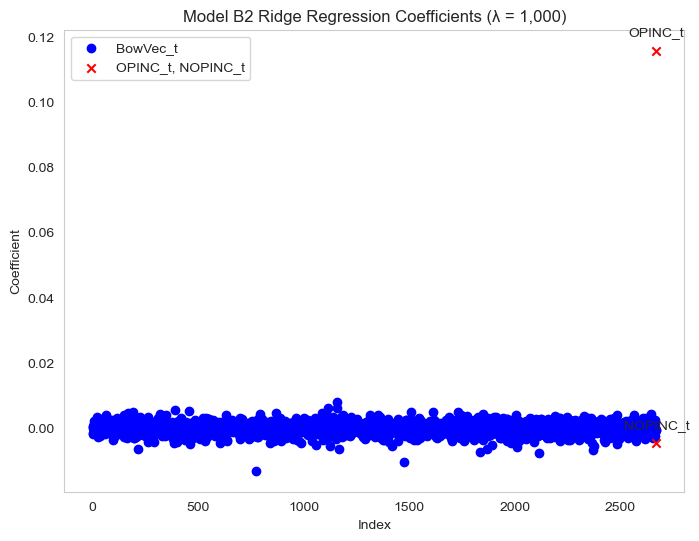

In [44]:
# Draw coefficients plot
model2_3_ridge_pkl = pickle.load(open('finalised-models/model2-3-ridge.pkl', 'rb'))
coefs = model2_3_ridge_pkl.coef_
coefs_bow = coefs[:-2]
coefs_comp = coefs[-2:]

plt.figure(figsize=(8, 6))
plt.scatter(range(len(coefs_bow)), coefs_bow, c='blue', label='BowVec_t', marker='o')
plt.scatter(range(len(coefs_bow), len(coefs_bow) + len(coefs_comp)), coefs_comp, c='red', label='OPINC_t, NOPINC_t', marker='x')
plt.annotate('OPINC_t', (2671, coefs_comp[0]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('NOPINC_t', (2672, coefs_comp[1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Index')
plt.ylabel('Coefficient')
plt.title('Model B2 Ridge Regression Coefficients (λ = 1,000)')
plt.legend()
plt.grid()
plt.show()

Model2.3 Decision tree

In [32]:
# with trial hyperparameters
model2_3_dt = DecisionTreeRegressor(max_depth=3)
model2_3_dt.fit(train_features_m2_3_norm, train_label_m2_3)

DecisionTreeRegressor(max_depth=3)

In [41]:
print('MSE: ', get_test_mse(
    model2_3_dt,
    test_features_m2_3_norm,
    test_label_m2_3
))

MSE:  0.04129093226297095


In [36]:
dt_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [10, 50, 100, 200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

model2_3_dt_tune = GridSearchCV(
    estimator=model2_3_dt,
    param_grid=dt_params,
    n_jobs=-1
)
model2_3_dt_tune.fit(train_features_m2_3_norm, train_label_m2_3)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/anaconda3/l

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [10, 50, 100, 200, 300, 500],
                         'splitter': ['best', 'random']})

In [37]:
model2_3_dt_tune.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 100,
 'splitter': 'best'}

In [38]:
model2_3_dt_best = model2_3_dt_tune.best_estimator_
print('MSE: ', get_test_mse(
    model2_3_dt_best,
    test_features_m2_3_norm,
    test_label_m2_3
))

print(
    'MAE: ',
    get_test_mae(
        model2_3_dt_best,
        test_features_m2_3_norm,
        test_label_m2_3
    )
)

n = test_data.shape[0]
p = train_features_m2_3_norm.shape[1]
print(
    'Adjusted R^2: ',
    get_test_adj_r2(
        model2_3_dt_best,
        test_features_m2_3_norm,
        test_label_m2_3,
        n,
        p
    )
)

MSE:  0.03999381879749871
MAE:  0.12397681374982314
Adjusted R^2:  0.18934121456443354


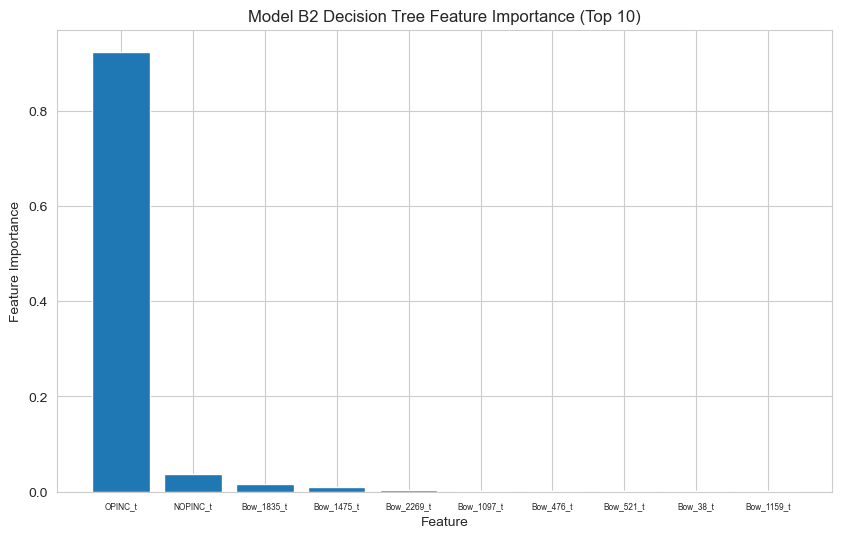

In [73]:
model2_3_dt_pkl = pickle.load(open('finalised-models/model2-3-dt.pkl', 'rb'))
feature_importances = model2_3_dt_pkl.feature_importances_
feature_names = [f"Bow_{i}_t" for i in range(1, 2671)] + ['OPINC_t', 'NOPINC_t']

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(0, 10), sorted_feature_importances[:10])
plt.xticks(range(0, 10), sorted_feature_names[:10], fontsize=6)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Model B2 Decision Tree Feature Importance (Top 10)')
plt.show()

Model2.3 Gradient boosting

In [39]:
model2_3_gb = GradientBoostingRegressor()

In [40]:
model2_3_gb.fit(train_features_m2_3_norm, train_label_m2_3)

GradientBoostingRegressor()

In [42]:
print('MSE: ', get_test_mse(
    model2_3_gb,
    test_features_m2_3_norm,
    test_label_m2_3
))

MSE:  0.038328713682948386


In [45]:
gb_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 10, 50, 100, 200],
    'min_samples_split': [2, 10, 100, 200, 500, 1000],
    'min_samples_leaf': [1, 10, 100, 200, 500, 1000],
}

# use RandomizedSearchCV for computational limitation
model2_3_gb_tune = RandomizedSearchCV(
    estimator=model2_3_gb,
    param_distributions=gb_params,
    random_state=42,
    n_iter=100,
    n_jobs=-1
)
model2_3_gb_tune.fit(train_features_m2_3_norm, train_label_m2_3)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [3, 10, 50, 100, 200],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 10, 100, 200,
                                                             500, 1000],
                                        'min_samples_split': [2, 10, 100, 200,
                                                              500, 1000],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42)

In [47]:
model2_3_gb_tune.best_params_

{'n_estimators': 150,
 'min_samples_split': 100,
 'min_samples_leaf': 200,
 'max_features': 'sqrt',
 'max_depth': 100}

In [48]:
model2_3_gb_best = model2_3_gb_tune.best_estimator_
print('MSE: ', get_test_mse(
    model2_3_gb_best,
    test_features_m2_3_norm,
    test_label_m2_3
))

MSE:  0.03826580442699687


In [49]:
print(
    'MAE: ',
    get_test_mae(
        model2_3_dt_best,
        test_features_m2_3_norm,
        test_label_m2_3
    )
)

n = test_data.shape[0]
p = train_features_m2_3_norm.shape[1]
print(
    'Adjusted R^2: ',
    get_test_adj_r2(
        model2_3_dt_best,
        test_features_m2_3_norm,
        test_label_m2_3,
        n,
        p
    )
)

MAE:  0.12397681374982314
Adjusted R^2:  0.18934121456443354


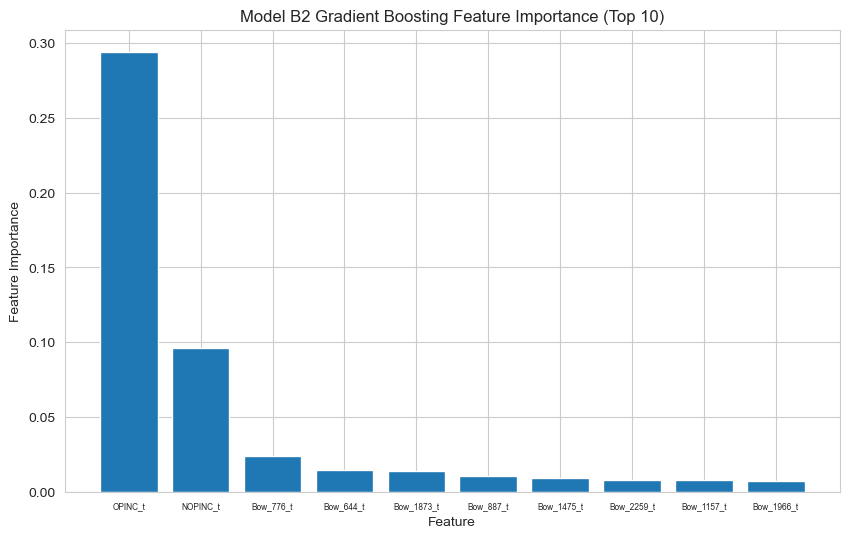

In [79]:
model2_3_gb_pkl = pickle.load(open('finalised-models/model2-3-gb.pkl', 'rb'))
feature_importances = model2_3_gb_pkl.feature_importances_
feature_names = [f"Bow_{i}_t" for i in range(1, 2671)] + ['OPINC_t', 'NOPINC_t']

sorted_indices = np.argsort(feature_importances)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(0, 10), sorted_feature_importances[:10])
plt.xticks(range(0, 10), sorted_feature_names[:10], fontsize=6)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Model B2 Gradient Boosting Feature Importance (Top 10)')
plt.show()

In [51]:
pickle.dump(model2_3_lr, open('finalised-models/model2-3-lr.pkl', 'wb'))
pickle.dump(model2_3_ridge, open('finalised-models/model2-3-ridge.pkl', 'wb'))
pickle.dump(model2_3_dt_best, open('finalised-models/model2-3-dt.pkl', 'wb'))
pickle.dump(model2_3_gb_best, open('finalised-models/model2-3-gb.pkl', 'wb'))